# Autoencoders

An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction. Recently, the autoencoder concept has become more widely used for learning generative models of data.

An autoencoder learns to compress data from the input layer into a short code, and then uncompress that code into something that closely matches the original data. This forces the autoencoder to engage in dimensionality reduction, for example by learning how to ignore noise. Autoencoders typically have a symmetric architecture:

<div style="display:block;margin:auto;width:500px;">
    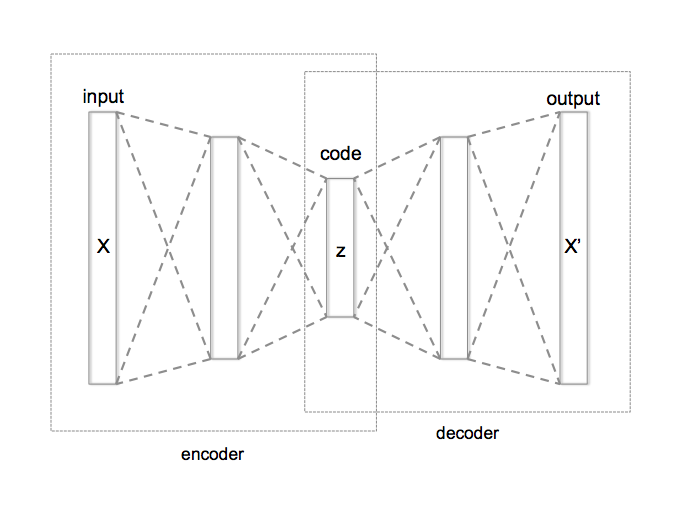
</div>
<div style="text-align:center;">**Symmetrical Autoencoder Architecture**</div>

Today two interesting practical applications of autoencoders are data denoising (which we feature later in this notebook), and dimensionality reduction for data visualization. With appropriate dimensionality and sparsity constraints, autoencoders can learn data projections that are more interesting than PCA or other basic techniques.

For 2D visualization specifically, t-SNE (pronounced "tee-snee") is probably the best algorithm around, but it typically requires relatively low-dimensional data. So a good strategy for visualizing similarity relationships in high-dimensional data is to start by using an autoencoder to compress your data into a low-dimensional space (e.g. 32 dimensional), then use t-SNE for mapping the compressed data to a 2D plane. Note that a nice parametric implementation of t-SNE in Keras was developed by Kyle McDonald and is available on Github. Otherwise scikit-learn also has a simple and practical implementation.

## Simple autoencoder
We'll start with a very simple autoencoder:

In [2]:
from keras.layers import Input, Dense
from keras.models import Model

from keras.datasets import mnist

import numpy as np;

In [3]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [4]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

In [5]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [6]:
# use pixel-wise binary cross-entropy loss
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [7]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [8]:
# note: fit on x_train, x_train
# validate on x_test, x_test
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 55us/step - loss: 0.3631 - val_loss: 0.2704
Epoch 2/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.2628 - val_loss: 0.2522
Epoch 3/50
60000/60000 [==============================] - 1s 21us/step - loss: 0.2429 - val_loss: 0.2312
Epoch 4/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.2225 - val_loss: 0.2117
Epoch 5/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.2058 - val_loss: 0.1979
Epoch 6/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.1940 - val_loss: 0.1877
Epoch 7/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.1851 - val_loss: 0.1798
Epoch 8/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.1780 - val_loss: 0.1734
Epoch 9/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.1721 - val_loss: 0.1679
Epoch

We can now visualize the results of our autoencoder:

In [6]:
from matplotlib import pyplot as plt

%matplotlib inline

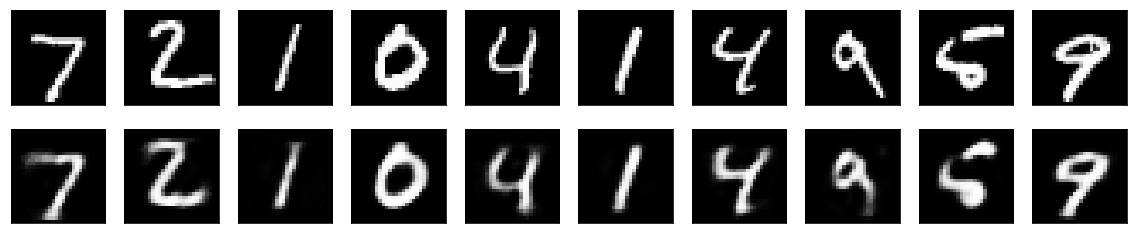

In [11]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

n = 10 
plt.figure(figsize=(20, 4))
for i in range(n):
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Convolutional autoencoder

Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [12]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

conv_autoencoder = Model(input_img, decoded)
conv_autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [13]:
from keras import backend as K

if K.image_data_format() == 'channels_last':
    shape_ord = (28, 28, 1)
else:
    shape_ord = (1, 28, 28)
    
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.reshape(x_train, ((x_train.shape[0],) + shape_ord))  
x_test = np.reshape(x_test, ((x_test.shape[0],) + shape_ord)) 

In [14]:
from keras.callbacks import TensorBoard

In [15]:
batch_size=128
steps_per_epoch = np.int(np.floor(x_train.shape[0] / batch_size))
conv_autoencoder.fit(x_train, x_train, epochs=50, batch_size=128,
                     shuffle=True, validation_data=(x_test, x_test),
                     callbacks=[TensorBoard(log_dir='./tf_autoencoder_logs')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 11s 182us/step - loss: 0.2125 - val_loss: 0.1660
Epoch 2/50
60000/60000 [==============================] - 9s 150us/step - loss: 0.1557 - val_loss: 0.1475
Epoch 3/50
60000/60000 [==============================] - 9s 144us/step - loss: 0.1403 - val_loss: 0.1345
Epoch 4/50
60000/60000 [==============================] - 9s 149us/step - loss: 0.1324 - val_loss: 0.1259
Epoch 5/50
60000/60000 [==============================] - 9s 157us/step - loss: 0.1275 - val_loss: 0.1262
Epoch 6/50
60000/60000 [==============================] - 9s 156us/step - loss: 0.1242 - val_loss: 0.1198
Epoch 7/50
60000/60000 [==============================] - 10s 159us/step - loss: 0.1217 - val_loss: 0.1158
Epoch 8/50
60000/60000 [==============================] - 10s 162us/step - loss: 0.1194 - val_loss: 0.1150
Epoch 9/50
60000/60000 [==============================] - 10s 168us/step - loss: 0.1178 - val_loss:

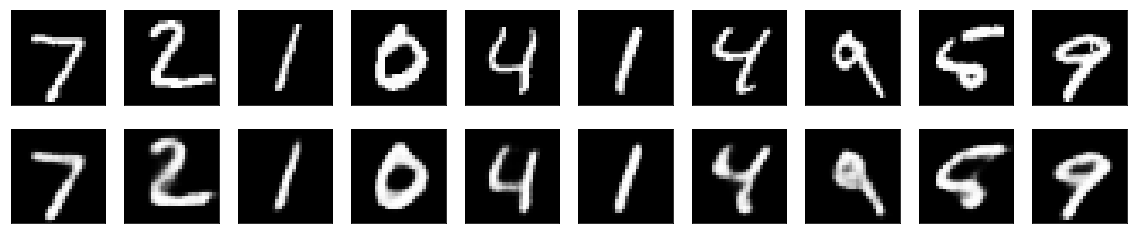

In [16]:
decoded_imgs = conv_autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Denoising autoencoder

Autoencoders can be applied quite effectively to parse the signal from noisy representations. We'll take a look at them here in the context of images that have had noise added to them.

In [4]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

# add noise to the training and test representations 
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

# make sure all pixel activations remain between 0 and 1 after noise has been added
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

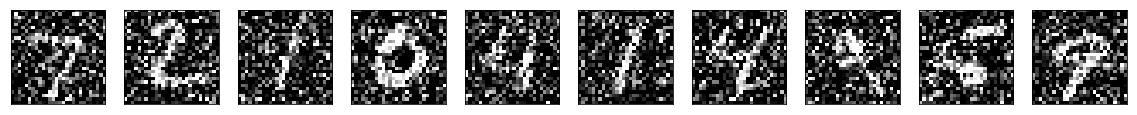

In [7]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

The added noise has modified the images significantly.

In [8]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model

from keras.callbacks import TensorBoard

In [9]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [10]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder_denoise', 
                                       histogram_freq=0, write_graph=False)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 16s 259us/step - loss: 0.1739 - val_loss: 0.1220
Epoch 2/100
60000/60000 [==============================] - 14s 231us/step - loss: 0.1198 - val_loss: 0.1125
Epoch 3/100
60000/60000 [==============================] - 12s 196us/step - loss: 0.1120 - val_loss: 0.1121
Epoch 4/100
60000/60000 [==============================] - 12s 195us/step - loss: 0.1083 - val_loss: 0.1056
Epoch 5/100
60000/60000 [==============================] - 12s 197us/step - loss: 0.1059 - val_loss: 0.1046
Epoch 6/100
60000/60000 [==============================] - 12s 200us/step - loss: 0.1043 - val_loss: 0.1017
Epoch 7/100
60000/60000 [==============================] - 13s 209us/step - loss: 0.1030 - val_loss: 0.1009
Epoch 8/100
60000/60000 [==============================] - 12s 204us/step - loss: 0.1023 - val_loss: 0.1010
Epoch 9/100
60000/60000 [==============================] - 12s 204us/step - loss: 0.10

Epoch 76/100
60000/60000 [==============================] - 15s 246us/step - loss: 0.0946 - val_loss: 0.0947
Epoch 77/100
60000/60000 [==============================] - 15s 246us/step - loss: 0.0947 - val_loss: 0.0942
Epoch 78/100
60000/60000 [==============================] - 15s 246us/step - loss: 0.0946 - val_loss: 0.0944
Epoch 79/100
60000/60000 [==============================] - 15s 245us/step - loss: 0.0946 - val_loss: 0.0944
Epoch 80/100
60000/60000 [==============================] - 15s 245us/step - loss: 0.0946 - val_loss: 0.0954
Epoch 81/100
60000/60000 [==============================] - 15s 246us/step - loss: 0.0945 - val_loss: 0.0944
Epoch 82/100
60000/60000 [==============================] - 15s 246us/step - loss: 0.0946 - val_loss: 0.0949
Epoch 83/100
60000/60000 [==============================] - 15s 249us/step - loss: 0.0945 - val_loss: 0.0943
Epoch 84/100
60000/60000 [==============================] - 15s 256us/step - loss: 0.0945 - val_loss: 0.0955
Epoch 85/100
60000/

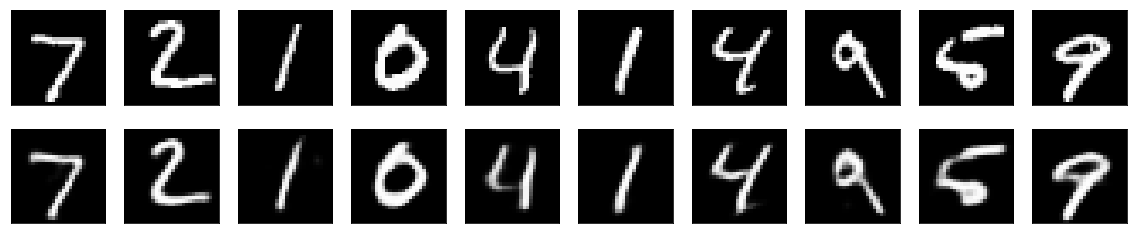

In [11]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()